# Rules of survival

### Mini-project

In this small project you will use the PRISM Rule Learner algorithm to learn some rules about COVID-19 comorbidity factors. Write as much about your findings as possible. You may add external information/additional datasets for an extra-credit.

## 1. Algorithm

Copy your implementation of the correct and tested algorithm in the cell below. You do not need to supply any comments or explanations. 

In [200]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

for list_of_files in os.listdir("../proj_ml_class_rules/data_sets"):
	print(list_of_files)

contact_lenses.csv
covid_categorical_good.csv
StudentEvaluations.csv
titanic.csv
two_houses.csv


In [201]:

data_file = "data_sets/covid_categorical_good.csv"
data = pd.read_csv(data_file)
data.columns



Index(['sex', 'age', 'diabetes', 'copd', 'asthma', 'imm_supr', 'hypertension',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'outcome'],
      dtype='object')

In [202]:

class Rule:
    def __init__(self, class_label):
        self.conditions = []  # list of conditions
        self.class_label = class_label  # rule class
        self.accuracy = 0
        self.coverage = 0

    def addCondition(self, condition):
        self.conditions.append(condition)

    def setParams(self, accuracy, coverage):
        self.accuracy = accuracy
        self.coverage = coverage
    
    # Human-readable printing of this Rule
    def __repr__(self):
        return "If {} then {}. Coverage:{}, accuracy: {}".format(self.conditions, self.class_label,
                                                                 self.coverage, self.accuracy)

class Condition:
    def __init__(self, attribute, value, true_false = None):
        self.attribute = attribute
        self.value = value
        self.true_false = true_false

    def __repr__(self):
        if self.true_false is None:
            return "{}={}".format(self.attribute, self.value)
        else:
            return "{}>={}:{}".format(self.attribute, self.value, self.true_false)



def learn_rules (columns, data, classes=None, 
                 min_coverage = 30, min_accuracy = 0.6):
    # List of final rules
    rules = []
    
    # If list of classes of interest is not provided - it is extracted from the last column of data
    if classes is not None:
        class_labels = classes
    else:
        class_labels = data[columns[-1]].unique().tolist()

    current_data = data.copy()
    
    # This follows the logic of the original PRISM algorithm
    # It processes each class in turn. 
    for class_label in class_labels:
        done = False
        while len(current_data) > min_coverage and not done:
            # Learn one rule 
            
            rule, subset = learn_one_rule(columns, current_data, class_label, min_coverage, min_accuracy)
            #print(current_data.shape, rule.accuracy)
            # If the best rule does not pass the coverage threshold - we are done with this class
            if rule is None:
                break

            # If we get the rule with accuracy and coverage above threshold
            
            if rule.accuracy >= min_accuracy:
                rules.append(rule)

                # remove rows covered by this rule
                # you have to remove the rows where all of the conditions hold
                current_data = current_data[~current_data.index.isin(subset.index)].copy()

            else:
                done = True         
                
    return rules


def learn_one_rule(columns, data, class_label, min_coverage = 30, min_accuracy = 0.6):
    covered_subset = data.copy()

    # YOUR CODE     
    #Creating an empty rule. 
    rule = Rule(class_label)
    
    # Creating a set for the available features.
    features = set(columns[:-1]) #Not including the last column (class_label)
    target = columns[-1]

    # As long there is a feature, we then create a a condition.
    while features:
        # The following best "attributes" are initialized to zero.
        # Checking the accuracy for each attribute and its values.
        best_accuracy = 0
        best_feature = None
        best_value = 0
        best_coverage = 0

        # This loop will run through each available feature.
        for col in features:
            # Calculates acurracy/coverage for specific feature.
            cur = covered_subset.groupby(col)[target].apply(lambda x: ((x == class_label).mean(),x.shape[0])).sort_values(ascending=False)
            cur = cur[cur.apply(lambda x: x[1] > min_coverage)]
            if cur.size == 0:
                continue

            # Selecting the best accuracy for the especific column.
            cur = cur.head(1) 

            # This keeps track of the best acurracy feature among features. 
            if best_accuracy < cur.values[0][0] or (cur.values[0][0] == best_accuracy and cur.values[0][1] > best_coverage):
                best_feature = col
                best_value = cur.index[0]
                best_accuracy = cur.values[0][0]
                best_coverage = cur.values[0][1]

        if best_feature is None:
            return None, None

        # After selecting a feature, we then remove it from the dataset so that we can avoid using it again in the next interation of the loop.
        features.remove(best_feature)
        # We then add the next condition to the rule to what is the best feature corresponding to the value. 
        rule.addCondition(Condition(best_feature, best_value))
        # We then only select the data specified by the rule.
        covered_subset = covered_subset[covered_subset[best_feature] == best_value].copy()
        # If the accuracy we achieve so far is higher than min_accuracy than we stopped.
        # If not, we then go back to the while loop.
        if best_accuracy > min_accuracy:
            break

    # We then achieve the minimal accuracy or there is no other feature to create the condition.
    rule.setParams(best_accuracy, covered_subset.shape[0])   

    # Here we then check if the coverage and the minimal accuracy is mantained.
    if (rule.coverage < min_coverage) or (rule.accuracy < min_accuracy): 
        rule = None 
        rule = None

    return rule, covered_subset                                                                

In [203]:
column_list = data.columns.to_numpy().tolist()
rules = learn_rules(column_list, data, None, 30, 0.95)
for rule in rules[:20]:
    print(rule)

If [age=6] then alive. Coverage:198, accuracy: 1.0
If [age=14] then alive. Coverage:360, accuracy: 0.9972222222222222
If [age=16] then alive. Coverage:492, accuracy: 0.9959349593495935
If [age=18] then alive. Coverage:611, accuracy: 0.9950900163666121
If [age=7] then alive. Coverage:182, accuracy: 0.9945054945054945
If [age=24] then alive. Coverage:2746, accuracy: 0.9941733430444283
If [age=19] then alive. Coverage:974, accuracy: 0.9928131416837782
If [age=12] then alive. Coverage:270, accuracy: 0.9925925925925926
If [age=20] then alive. Coverage:1191, accuracy: 0.9916036943744753
If [age=8] then alive. Coverage:215, accuracy: 0.9906976744186047
If [age=25] then alive. Coverage:3235, accuracy: 0.9901081916537867
If [age=27] then alive. Coverage:4053, accuracy: 0.9898840365161609
If [age=28] then alive. Coverage:4298, accuracy: 0.9895300139599814
If [age=23] then alive. Coverage:2129, accuracy: 0.9891968060122123
If [age=11] then alive. Coverage:272, accuracy: 0.9889705882352942
If [age

In [204]:
cur = data.groupby('age')['outcome'].apply(lambda x: ((x == 'alive').mean(),x.shape[0])).sort_values(ascending=False)
cur = cur[cur.apply(lambda x: x[1] > 30)]
cur

age
6                    (1.0, 198)
14    (0.9972222222222222, 360)
16    (0.9959349593495935, 492)
18    (0.9950900163666121, 611)
7     (0.9945054945054945, 182)
                ...            
87    (0.5420289855072464, 345)
83     (0.535958904109589, 584)
88    (0.5284552845528455, 246)
93     (0.5194805194805194, 77)
86    (0.5119363395225465, 377)
Name: outcome, Length: 98, dtype: object

## 2. Titanic dataset: the rules of survival

Our very familiar Titanic [dataset](https://docs.google.com/spreadsheets/d/1QGNxqRU02eAvTGih1t0cErB5R05mdOdUBgJZACGcuvs/edit?usp=sharing).

In [205]:
for list_of_files in os.listdir("../data_sets"):
	print(list_of_files)


contact_lenses.csv
covid_categorical_good.csv
StudentEvaluations.csv
titanic.csv
two_houses.csv


In [206]:
data = pd.read_csv("../data_sets/titanic.csv")

# take a subset of attributes
data = data[['Pclass', 'Sex', 'Age', 'Survived']]

# drop all columns and rows with missing values
data = data.dropna(how="any")
print("Total rows", len(data))

column_list = data.columns.to_numpy().tolist()
print("Columns:", column_list)

Total rows 714
Columns: ['Pclass', 'Sex', 'Age', 'Survived']


In [207]:
data.head(-10)

,Pclass,Sex,Age,Survived
0,3,male,22.0,0
1,1,female,38.0,1
2,3,female,26.0,1
3,1,female,35.0,1
4,3,male,35.0,0
...,...,...,...,...
874,2,female,28.0,1
875,3,female,15.0,1
876,3,male,20.0,0
877,3,male,19.0,0


In [208]:
data.shape


(714, 4)

In [209]:
data['Sex'].value_counts()

male      453
female    261
Name: Sex, dtype: int64

In [210]:
print("Percentage of deaths by Pclass and Sex:\n")
sex_pClassData = data.groupby(['Pclass', 'Sex'])['Survived'].apply(lambda x: (x== 0).mean()).sort_values()
sex_pClassData

Percentage of deaths by Pclass and Sex:



Pclass  Sex   
1       female    0.035294
2       female    0.081081
3       female    0.539216
1       male      0.603960
2       male      0.848485
3       male      0.849802
Name: Survived, dtype: float64

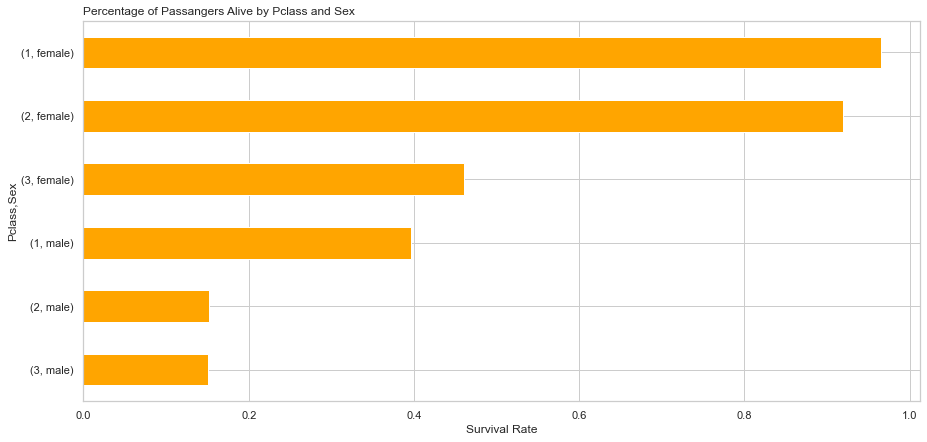

In [211]:
sex_pClassData = data.groupby(['Pclass', 'Sex'])['Survived'].apply(lambda x: (x== 1).mean()).sort_values()
plt.xlabel('Survival Rate')
plt.ylabel('Pclass by Sex')
sex_pClassData.plot.barh(figsize =(15,7), color = "orange").set_title('Percentage of Passangers Alive by Pclass and Sex', loc='left')

plt.show()





In [212]:
# We can set different accuracy thresholds
# Here we can reorder class labels - to first learn the rules with class label "survived".
rules = learn_rules(column_list, data, [1,0], 30, 0.7)
for rule in rules[:10]:
    print(rule)

If [Sex=female] then 1. Coverage:261, accuracy: 0.7547892720306514
If [Pclass=3] then 0. Coverage:253, accuracy: 0.849802371541502
If [Pclass=2] then 0. Coverage:99, accuracy: 0.8484848484848485


## 3. Coronavirus: symptoms and outcome

In [213]:
data_file = "../data_sets/covid_categorical_good.csv"
data = pd.read_csv(data_file)
data = data.dropna(how="any")
column_list = data.columns

Most accurate rules will have class label "alive". There could be too many rules, and we might never get to the class label "dead" if we rank them by accuracy. 

If we want to see which combination of attributes leads to "dead", we might want to run the algorithm with only this class label and set the lower accuracy threshold.

Remove the _age_ attribute and run your algorithm with parameters shown below.

In [214]:
data.head()

,sex,age,diabetes,copd,asthma,imm_supr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,outcome
0,male,27,no,no,no,no,no,no,no,no,no,alive
1,male,24,no,no,no,no,no,no,no,no,no,alive
2,female,54,no,no,no,no,no,no,yes,no,no,alive
3,male,30,no,no,no,no,no,no,no,no,no,alive
4,female,60,yes,no,no,no,yes,yes,no,no,no,dead


In [215]:
data['outcome'].value_counts()

alive    192419
dead      26760
Name: outcome, dtype: int64

In [216]:
data.groupby('age')['outcome'].apply(lambda x: (x== 'dead').mean()).sort_values()

age
120    0.000000
106    0.000000
114    0.000000
102    0.000000
6      0.000000
         ...   
83     0.464041
88     0.471545
93     0.480519
86     0.488064
100    0.500000
Name: outcome, Length: 109, dtype: float64

In [217]:
data.groupby('age')['outcome'].apply(lambda x: (x== 'alive').mean()).sort_values()

age
100    0.500000
86     0.511936
93     0.519481
88     0.528455
83     0.535959
         ...   
106    1.000000
114    1.000000
116    1.000000
6      1.000000
120    1.000000
Name: outcome, Length: 109, dtype: float64

In [228]:
aliveData = data.groupby(['sex', 'age','diabetes','copd','asthma','imm_supr','hypertension','cardiovascular','obesity','renal_chronic','tobacco'])['outcome'].apply(lambda x: (x== "alive").mean()).sort_values()
deadData = data.groupby(['sex', 'age','diabetes','copd','asthma','imm_supr','hypertension','cardiovascular','obesity','renal_chronic','tobacco'])['outcome'].apply(lambda x: (x== "dead").mean()).sort_values()

In [241]:
print(aliveData,"\n\n", "*"*115,"\n", deadData)

sex     age  diabetes  copd  asthma  imm_supr  hypertension  cardiovascular  obesity  renal_chronic  tobacco
female  52   yes       no    yes     no        yes           yes             no       yes            no         0.0
male    63   yes       no    no      no        no            no              yes      no             yes        0.0
female  87   yes       no    no      no        no            no              no       yes            no         0.0
male    63   yes       no    no      no        yes           no              no       yes            yes        0.0
                                                             yes             no       yes            yes        0.0
                                                                                                               ... 
female  71   no        no    yes     no        yes           no              no       no             yes        1.0
                       yes   no      no        no            no              no

In [219]:
# We really want to learn first what makes covid deadly
class_labels = ["dead"]
rules = learn_rules(column_list, data, class_labels, 30, 0.9) 
for rule in rules[:20]:
    print(rule)

In [220]:
# I had to lower the accuracy and coverage in order to see more rules that would include the dead.
class_labels = ["dead"]
rules = learn_rules(column_list, data, class_labels, 22, 0.4) 
for rule in rules[:20]:
    print(rule)

If [age=86] then dead. Coverage:377, accuracy: 0.4880636604774536
If [age=93] then dead. Coverage:77, accuracy: 0.4805194805194805
If [age=88] then dead. Coverage:246, accuracy: 0.4715447154471545
If [age=83] then dead. Coverage:584, accuracy: 0.464041095890411
If [age=87] then dead. Coverage:345, accuracy: 0.4579710144927536
If [age=80] then dead. Coverage:820, accuracy: 0.4573170731707317
If [age=82] then dead. Coverage:656, accuracy: 0.4573170731707317
If [age=81] then dead. Coverage:693, accuracy: 0.45454545454545453
If [age=84] then dead. Coverage:547, accuracy: 0.4369287020109689
If [age=78] then dead. Coverage:1034, accuracy: 0.43133462282398455
If [age=91] then dead. Coverage:117, accuracy: 0.42735042735042733
If [age=79] then dead. Coverage:851, accuracy: 0.418331374853114
If [age=76] then dead. Coverage:1118, accuracy: 0.41323792486583183
If [age=74] then dead. Coverage:1281, accuracy: 0.4129586260733802
If [age=92] then dead. Coverage:109, accuracy: 0.41284403669724773
If [a

Now try on both classes and for the entire dataset including _age_. Collect top 20 most accurate rules.

In [221]:
# This may take some time to run (took 12 min on my computer - what about your implementation?)
rules = learn_rules (column_list, data, None, 30, 0.9)
for rule in rules[:20]:
    print(rule)

If [age=6] then alive. Coverage:198, accuracy: 1.0
If [age=14] then alive. Coverage:360, accuracy: 0.9972222222222222
If [age=16] then alive. Coverage:492, accuracy: 0.9959349593495935
If [age=18] then alive. Coverage:611, accuracy: 0.9950900163666121
If [age=7] then alive. Coverage:182, accuracy: 0.9945054945054945
If [age=24] then alive. Coverage:2746, accuracy: 0.9941733430444283
If [age=19] then alive. Coverage:974, accuracy: 0.9928131416837782
If [age=12] then alive. Coverage:270, accuracy: 0.9925925925925926
If [age=20] then alive. Coverage:1191, accuracy: 0.9916036943744753
If [age=8] then alive. Coverage:215, accuracy: 0.9906976744186047
If [age=25] then alive. Coverage:3235, accuracy: 0.9901081916537867
If [age=27] then alive. Coverage:4053, accuracy: 0.9898840365161609
If [age=28] then alive. Coverage:4298, accuracy: 0.9895300139599814
If [age=23] then alive. Coverage:2129, accuracy: 0.9891968060122123
If [age=11] then alive. Coverage:272, accuracy: 0.9889705882352942
If [age

## 4. Discussion

Write here a discussion about the rules that you have learned from both datasets. 

Did any of these rules surprise you?

Do you have a meaningful logical explanation for these rules?

What additional research is needed to understand the meaning of your findings?

## Answer:


I was not surprised by rules generated from the titanic dataset. 


. This is because, due to the historical context of when the event occurred, it is possible to link the survival rate to the inequality of services between social classes. For the titanic dataset, we had the following rules.

    If [Sex=female] then 1. Coverage:261, accuracy: 0.7547892720306514
    If [Pclass=3] then 0. Coverage:253, accuracy: 0.849802371541502
    If [Pclass=2] then 0. Coverage:99, accuracy: 0.8484848484848485

It makes sense that, among other groups, females have a better chance of survival. We can also note that the rules show that higher "Pclass" leads to a higher chance of death. Which means that the higher the acquisition power, the greater the chance of survival. 

As for the covid_categorical_good dataset, I first noticed that there were a smaller number of "dead" cases (26760) from a total of (192419) "alive" cases. Additionally, we do not see any of the rules with "dead" class_label being show up in top 20 rules. While testing the rules with lower accuracy and coverage, we can see  that most of the accuracy of the "dead" are really low. Thus, it seems that we can not find any rule that will be always "dead". For example, if we were to consider only patients at age 79, the chances of all of these patients to die is very low. For that reason, we can not get 100% accuracy. All the top 20 rules with the "alive" class has its majority with higher accuracy. Finally, it seems that "age" is the dataset feature with the most important factor to determine the survival chance of someone with covid-19. 


Copyright &copy; 2022 Marina Barsky. All rights reserved.